In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump, load
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ================== CONFIG (Same as before) ==================
TARGET_NEURON = "Neuron_0"
SEQUENCE_LENGTH = 1
TEST_RUNS = 10
EPOCHS = 10
BATCH_SIZE = 64
DATA_FILE_PATH = "./data/spike_dataset.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define new model/scaler paths
MODEL_PATH = "./data/aval_predictor_spike.pth"
FEATURE_SCALER_PATH = "./data/feature_scaler_sub_spike.joblib"
TARGET_SCALER_PATH = "./data/target_scaler_sub_spike.joblib"

In [5]:
# ================== DATA PREP WITH CENSORING ==================
def load_and_prepare_data():
    df = pd.read_csv(DATA_FILE_PATH)

    # --- 1. Define Spike Threshold (Your Method) ---
    target_mean = df[TARGET_NEURON].mean()
    target_std = df[TARGET_NEURON].std()
    spike_threshold = target_mean + 3 * target_std
    print(f"Calculated spike threshold: {spike_threshold:.2f} mV")

    # --- The rest is the same as before ---
    all_runs = df["run"].unique()
    train_val_runs,  test_runs = train_test_split(
        all_runs, test_size=TEST_RUNS, random_state=42
    )
    train_runs, validation_runs = train_test_split(
    train_val_runs, test_size=TEST_RUNS, random_state=42
    )
    
    train_df = df[df["run"].isin(train_runs)]
    validation_df = df[df["run"].isin(validation_runs)]

    feature_columns = df.columns.drop(["run", "time"])
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    train_df_scaled = train_df.copy()
    train_df_scaled[feature_columns] = feature_scaler.fit_transform(
        train_df[feature_columns]
    )
    train_df_scaled[[TARGET_NEURON]] = target_scaler.fit_transform(
        train_df[[TARGET_NEURON]]
    )

    validation_df_scaled = validation_df.copy()
    validation_df_scaled[feature_columns] = feature_scaler.transform(validation_df[feature_columns])
    validation_df_scaled[[TARGET_NEURON]] = target_scaler.transform(validation_df[[TARGET_NEURON]])
    
    return (
        train_df_scaled,
        validation_df_scaled,
        feature_columns,
        feature_scaler,
        target_scaler,
        train_runs,
        test_runs
    )

def process_classification_data(df_test, threshold, neuron_col=TARGET_NEURON, window_radius=1):
    # Step 1: Find spike indices and create a spike mask
    spike_indices_test = df_test.index[df_test[neuron_col] > threshold].tolist()
    spike_mask = np.zeros(len(df_test), dtype=bool)
    
    for i in spike_indices_test:
        if i >= window_radius and i + window_radius < len(df_test):
            spike_mask[i] = True

    # Step 2: Create test windows and labels
    X_test = []
    y_test = []

    for i in range(window_radius, len(df_test) - window_radius):
        window = df_test.iloc[i - window_radius : i + window_radius + 1].values
        X_test.append(window.flatten())
        y_test.append(int(spike_mask[i]))

    # Convert lists to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_test, y_test


def create_sequences(df, feature_columns):
    # For each run, just take all features and target as-is
    X, y = [], []
    for run_id in df["run"].unique():
        run_features = df[df["run"] == run_id][feature_columns].values
        run_target = df[df["run"] == run_id][TARGET_NEURON].values
        X.append(run_features)
        y.append(run_target)
    
    # Concatenate all runs
    X = np.vstack(X).astype(np.float32)
    y = np.hstack(y).astype(np.float32)
    
    # Add a dummy "sequence" dimension so it matches (batch, seq_len=1, features)
    X = X[:, np.newaxis, :]
    
    return X, y


class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Flatten since seq_len = 1
        x = x.squeeze(1)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)


# ================== TRAINING ==================
def train_specialist_model():
    # Load the newly censored data
    train_df, validation_df, feature_columns, f_scaler, t_scaler, train_runs, test_runs = (
        load_and_prepare_data()
    )
    X_train, y_train = create_sequences(train_df, feature_columns)
    X_val, y_test = create_sequences(validation_df, feature_columns)

    # The rest of the training process is identical
    train_ds = torch.utils.data.TensorDataset(
        torch.tensor(X_train), torch.tensor(y_train).unsqueeze(-1)
    )
    validation_ds = torch.utils.data.TensorDataset(
        torch.tensor(X_val), torch.tensor(y_test).unsqueeze(-1)
    )
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(validation_ds, batch_size=BATCH_SIZE)

    model = MLPRegressor(len(feature_columns)).to(DEVICE)
    pos_weight = torch.tensor([5.0])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print("\n--- Training Sub-Threshold Specialist Model ---")
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                val_loss += criterion(model(xb), yb).item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Val Loss: {val_loss/len(test_loader):.6f}")

    os.makedirs("./results", exist_ok=True)
    torch.save(model.state_dict(), MODEL_PATH)
    dump(f_scaler, FEATURE_SCALER_PATH)
    dump(t_scaler, TARGET_SCALER_PATH)
    print("Specialist model and new scalers saved.")

    return train_runs, test_runs


# Run the training
train_runs, test_runs = train_specialist_model()


Calculated spike threshold: -30.74 mV

--- Training Sub-Threshold Specialist Model ---
Epoch 1/10, Val Loss: 0.000048
Epoch 2/10, Val Loss: 0.000007
Epoch 3/10, Val Loss: 0.000007
Epoch 4/10, Val Loss: 0.000002
Epoch 5/10, Val Loss: 0.000004
Epoch 6/10, Val Loss: 0.000002
Epoch 7/10, Val Loss: 0.000009
Epoch 8/10, Val Loss: 0.000015
Epoch 9/10, Val Loss: 0.000001
Epoch 10/10, Val Loss: 0.000030
Specialist model and new scalers saved.


Loading model, scalers, and original data for final prediction...
Generating final hybrid autoregressive prediction...
Plotting final results...


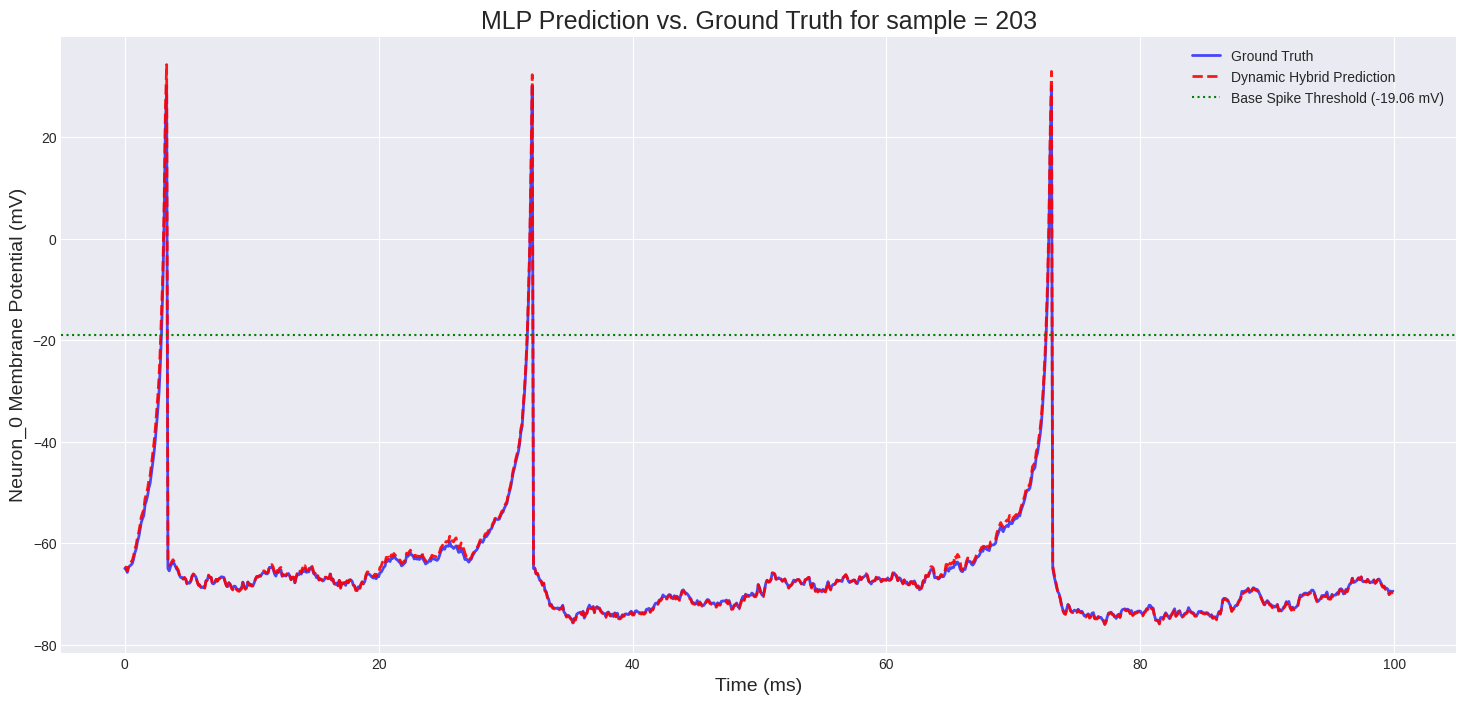

Loading model, scalers, and original data for final prediction...
Generating final hybrid autoregressive prediction...
Plotting final results...


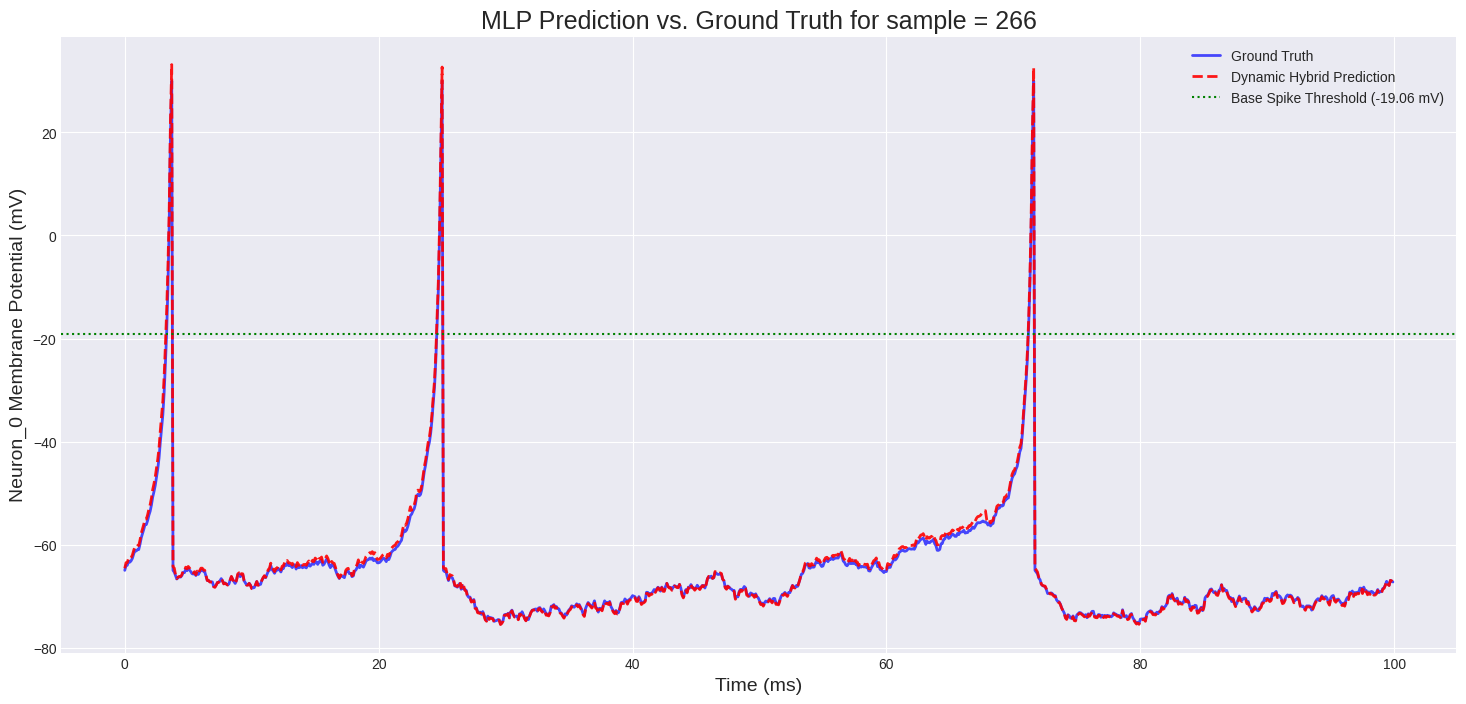

In [7]:
# ================== DYNAMIC HYBRID PREDICTION ==================
def run_dynamic_hybrid_prediction(RUN_TO_TEST = 25):
    # --- 1. Load all components ---
    print("Loading model, scalers, and original data for final prediction...")
    df = pd.read_csv("./data/spike_dataset.csv")
    feature_scaler = load(FEATURE_SCALER_PATH)
    target_scaler = load(TARGET_SCALER_PATH)
    feature_columns = df.columns.drop(["run", "time"])

    model = MLPRegressor(len(feature_columns)).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    # --- 2. Define Dynamic Threshold and Spike Properties ---
    aval_mean = df[TARGET_NEURON].mean()
    aval_std = df[TARGET_NEURON].std()

    SPIKE_PEAK_MV = target_scaler.inverse_transform(np.array([[1]]))[0, 0]
    SPIKE_THRESHOLD_BASE_MV = np.array(aval_mean + 4 * aval_std, SPIKE_PEAK_MV).min()

    # --- 3. Prepare Test Data ---
    test_run_df = df[df["run"] == RUN_TO_TEST].copy()
    test_run_df_scaled = test_run_df.copy()
    test_run_df_scaled[feature_columns] = feature_scaler.transform(test_run_df[feature_columns])

    # --- 4. Autoregressive Prediction with CORRECTED Logic ---
    print("Generating final hybrid autoregressive prediction...")
    
    # Create all input sequences for the test run at once
    X_single_run, _ = create_sequences(test_run_df_scaled, feature_columns)
    predictions_scaled = []
    
    for i in range(len(X_single_run)):
        current_sequence = torch.tensor(X_single_run[i], dtype=torch.float32).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            next_pred_scaled = model(current_sequence).item()
        predictions_scaled.append(next_pred_scaled) # Use the LSTM prediction

    # --- 5. Process and Plot Results ---
    print("Plotting final results...")
    max_len = len(test_run_df)
    predictions_rescaled = target_scaler.inverse_transform(np.array(predictions_scaled[:max_len]).reshape(-1, 1))
    ground_truth_rescaled = test_run_df[TARGET_NEURON]
    time = test_run_df['time']

    plt.style.use("seaborn-v0_8-darkgrid")
    plt.figure(figsize=(18, 8))
    plt.plot(time, ground_truth_rescaled, label="Ground Truth", color="blue", linewidth=2, alpha=0.7)
    plt.plot(time, predictions_rescaled, label="Dynamic Hybrid Prediction", color="red", linestyle="--", linewidth=2, alpha=0.9)
    plt.axhline(y=SPIKE_THRESHOLD_BASE_MV, color='green', linestyle=':', label=f'Base Spike Threshold ({SPIKE_THRESHOLD_BASE_MV:.2f} mV)')
    plt.title(f"MLP Prediction vs. Ground Truth for sample = {RUN_TO_TEST}", fontsize=18)
    plt.xlabel("Time (ms)", fontsize=14)
    plt.ylabel(f"{TARGET_NEURON} Membrane Potential (mV)", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.savefig("./results/final_dynamic_hybrid_prediction_plot.png")
    plt.show()


for i in test_runs[:2]:
    run_dynamic_hybrid_prediction(i)